# Tile Coding

Tile coding is a very innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_, and then for any given sample value, check which tiles does it lie in. You can then encode the original continuous value by a vector of integer indices or bits that identify each activated tile.

> **Tip**: You can run each code block below by pressing **`Shift+Enter`**. Look for any **`TODO`** comments and implement the indicated code. Also try to answer any questions (**Q:**) by editing the corresponding answer (**A:**) block.

In [1]:
# Import common libraries
import gym
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.

> **Note**: You can run this notebook locally (use `render_mode = 'desktop'`), or in an online workspace / cloud instance (use `render_mode = 'jupyter'`, to visualize the simulation within the notebook). But visualization can be quite slow (esp. in the notebook), so you may want to set it to `None` to suppress visualization when you're ready to run a long batch. It is always recommended to download and run the notebook on your local machine.

In [2]:
# Global render settings
render_mode = 'desktop'  # set to 'desktop' (when running on local machine) or 'jupyter' (in notebook, slow)

# Start a virtual display if you wish to render within the jupyter notebook (needed for certain envs)
if render_mode == 'jupyter':
    !pip install pyvirtualdisplay  # install pyvirtualdisplay, one-time only
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0)
    virtual_display.start()

## Continuous State Space

As in the case of grid-based discretization, let's begin with an environment that has a continuous state space, but a discrete action space.

In [3]:
# Create an environment
env = gym.make('Acrobot-v1')

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

[2018-04-28 10:21:21,086] Making new env: Acrobot-v1


State space: Box(6,)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [  1.      1.      1.      1.     12.566  28.274]
Action space: Discrete(3)


Think about the state space–it is multidimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the remaining two have a larger range. How do we discretize such a space using tiles?

## Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

E.g. if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[[-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7],
 [-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5]]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, esp. along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [4]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    tmp = np.array([low, high]).transpose()
    grid = np.ndarray(shape=(tmp.shape[0], bins[0] - 1))
    offsets = np.array(offsets)
    for i in range(tmp.shape[0]):
        tmp2 = np.array(tmp[i])
        categories = pd.cut(tmp2, bins[i]).categories
        for j in range(len(categories) - 1):
            grid[i][j] = (categories[j].right) + offsets[i]
    return grid

low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

array([[-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7],
       [-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5]])

You can now use this function to define a set of tilings that are a little offset from each other.

In [5]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    tiles = []
    for spec in tiling_specs:
        tile = create_tiling_grid(low, high, spec[0], spec[1])
        tiles.append(tile)
    return tiles


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)
print(np.array(tilings).shape)

(3, 2, 9)


It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

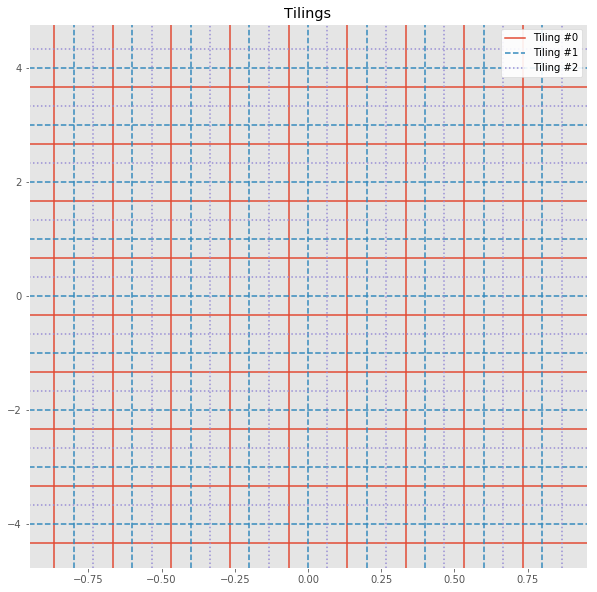

In [6]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

Great! Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

## Tile Encoding

Implement the following to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles you have, or it can be ultimately flattened for convenience.

You can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [7]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    discrete_sample = np.ndarray(shape=(len(sample), ), dtype=np.int)
    for i in range(len(sample)):
        discrete_sample[i] = np.digitize(sample[i], grid[i])
    return tuple(discrete_sample)


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    encoded_samples = []
    for each in tilings:
        encoded_sample = discretize(sample, each)
        encoded_samples.append(encoded_sample)
    
    if flatten:
        return encoded_samples.flatten
        
    return encoded_samples


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]


Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

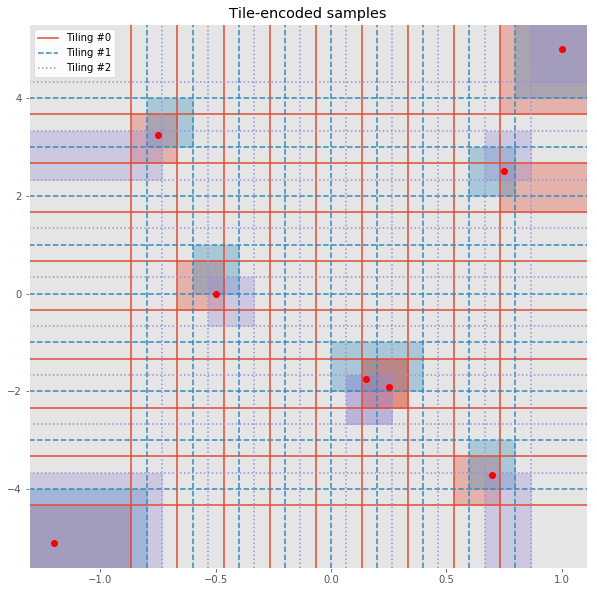

In [8]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax


visualize_encoded_samples(samples, encoded_samples, tilings);

Inspect the results and make sure you understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.

## Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow you to update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation as and when required.

In [9]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size,
                 alpha=0.1, gamma=0.9,
                 epsilon=0.5, epsilon_decay_rate=0.99):
        """Create tilings, initialize internal Q-table(s) and learning parameters
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        
        print("Tilings shape:", np.array(self.tilings).shape)
        print("State sizes:", self.state_sizes)
        print("Action size:", self.action_size)
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
        
        # learning parameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        
    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate

        # Decide initial action
        self.last_state = state
        self.last_action = self.get_action(self.last_state)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
        
    def get_action(self, state):
        """
        Get the best action for the state - select the best action from each Q-Table
        and use the weight to select the best one
        """
        encoded_state = tile_encode(state, self.tilings)
        
        action_dict = {}
        for i, q_table in enumerate(self.q_tables):
            value = np.max(q_table.q_table[encoded_state[i]])
            action = np.argmax(q_table.q_table[encoded_state[i]])
            if action in action_dict:
                action_dict[action] += value
            else:
                action_dict[action] = value
                
        action_dict_sorted = sorted(action_dict, key=action_dict.__getitem__, reverse=True)
        return action_dict_sorted[0]
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # TODO: Retrieve q-value for each tiling, and return their average
        value = 0
        for i, q_table in enumerate(self.q_tables):
            value += q_table.q_table[encoded_state[i] + (action,)]
        value = value / len(self.q_tables)
        return value

    def update(self, state, action, reward, value):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # TODO: Update q-value for each tiling by update factor alpha
        for i, q_table in enumerate(self.q_tables):
            q_table.q_table[encoded_state[i] + (action,)] += self.alpha * \
                (reward + self.gamma * value - q_table.q_table[encoded_state[i] + (action,)])
                
    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        if mode == 'test':
            # Test mode: Simply produce an action
            # Get tiling with maximum Q-Value for a given state - its argmax is an action
            action = self.get_action(state)
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            value = self.get(state, self.last_action)
            self.update(self.last_state, self.last_action, reward, value)
            
            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                # Get tiling with maximum Q-Value for a given state - its argmax is an action
                action = self.get_action(state)

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0; r = 1
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, r, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
Tilings shape: (3, 2, 9)
State sizes: [(10, 10), (10, 10), (10, 10)]
Action size: 2
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.12666666666666668


If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### Exercise: Implement a Q-Learning Agent using Tile-Coding

Now it's your turn to apply this discretization technique to design and test a complete learning agent! Compare the learning performance of your new agent with previous discretization approaches you have applied.

In [10]:
def run(agent, env, num_episodes=1000, mode='train',
        render_mode='desktop', render_every=100, jupyter_frame_interval=15):
    """Run agent in given reinforcement learning environment and return episode rewards."""
    episode_rewards = []

    try:
        for e in tqdm(range(num_episodes), disable=(render_mode=='jupyter')):
            # Initialize episode
            state = env.reset()
            action = agent.reset_episode(state)
            t = 0
            total_reward = 0
            done = False

            if render_mode == 'jupyter':
                img = plt.imshow(env.render(mode='rgb_array'))  # [jupyter] one-time only
                plt.axis('off')

            # Roll out steps till done
            while not done:
                state, reward, done, info = env.step(action)
                total_reward += reward
                action = agent.act(state, reward, done, mode)
                if render_mode and e % render_every == 0:  # only display certain episodes
                    if render_mode == 'jupyter':
                        if t % jupyter_frame_interval == 0:
                            img.set_data(env.render(mode='rgb_array'))  # [jupyter] just update the data
                            display.display(plt.gcf())
                            display.clear_output(wait=True)
                    else:
                        env.render(mode='human', close=done)
                t += 1

            # Collect episode reward
            episode_rewards.append(total_reward)
    except KeyboardInterrupt:
        pass
    finally:
        if render_mode:
            env.render(close=True)

    return episode_rewards

In [11]:
# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10, 10, 10, 10, 10), (-0.1, -0.1, -0.1, -0.1, -1, -3)),
                ((10, 10, 10, 10, 10, 10), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)),
                ((10, 10, 10, 10, 10, 10), (0.1, 0.1, 0.1, 0.1, 1, 3))]
q_agent = TiledQTable(env.observation_space.low, env.observation_space.high, tiling_specs, env.action_space.n)

QTable(): size = (10, 10, 10, 10, 10, 10, 3)
QTable(): size = (10, 10, 10, 10, 10, 10, 3)
QTable(): size = (10, 10, 10, 10, 10, 10, 3)
Tilings shape: (3, 6, 9)
State sizes: [(10, 10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10)]
Action size: 3
TiledQTable(): no. of internal tables =  3


In [12]:
episode_rewards = run(q_agent, env, num_episodes=1000, render_every=100, render_mode=render_mode)
print("Completed {} episodes with avg. reward = {}".format(len(episode_rewards), np.mean(episode_rewards)))

100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]

Completed 1000 episodes with avg. reward = -457.21


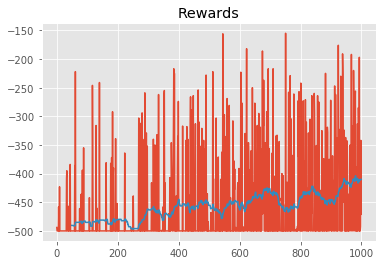

In [13]:
def plot_rewards(rewards, rolling_window=None):
    """Plot rewards and optional rolling mean using specified window."""
    plt.plot(rewards); plt.title("Rewards");
    if rolling_window is not None:
        plt.plot(pd.Series(rewards).rolling(rolling_window).mean());


window_size = 50  # choose a suitable window size, e.g. int(len(episode_rewards) / 25)
plot_rewards(episode_rewards, rolling_window=window_size)